In [ ]:
!python -V

In [ ]:
!pip install "numpy<2.0.0" pandas==2.0.3 pyarrow==12.0.1

In [ ]:
!pip install seaborn matplotlib scikit-learn

In [1]:
import numpy as np
import pandas as pd
import pyarrow
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"PyArrow: {pyarrow.__version__}")

NumPy: 1.26.4
Pandas: 2.0.3
PyArrow: 12.0.1


In [2]:
import pickle

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [5]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
    df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)
    mask = ((df.duration >= 1) & (df.duration <= 60))
    df = df[mask].copy()
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [6]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [7]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [9]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

# X_train is a sparse matrix we use as the input
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

# y_train is a simple list containg the duration of each trip
target = 'duration'
y_train = df_train[target].values

# Actual training is here, LinearRegression tries to solve an equation: y = w_1x_1 + w_2x_2 + ... + b.
lr = LinearRegression()
# After the .fit(), lr now contains the calculated weights that represent the "patterns" it found
lr.fit(X_train, y_train)

# Here we asked the trained model to predict duration based on X_train
y_pred = lr.predict(X_train)
# Compare its prediction with actual duration data to see how good it is
root_mean_squared_error(y_train, y_pred)

9.838799799829628

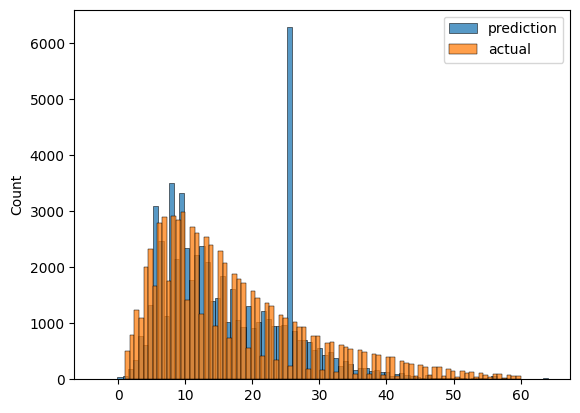

In [22]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

In [18]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [19]:
categorical = ['PU_DO']
# Repeat the process to get the sparse matrix
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

# This time we make a matrix from Feb data
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)


7.758715200888857

In [30]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

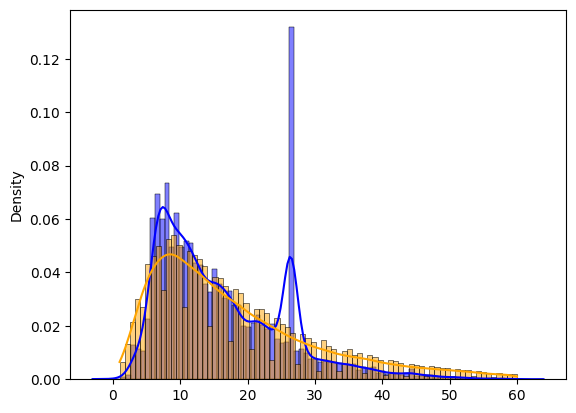

In [29]:
# Use histplot with kde=True to replace the deprecated distplot
sns.histplot(y_pred, label='prediction', kde=True, color='blue', stat="density", alpha=0.5)
sns.histplot(y_val, label='actual', kde=True, color='orange', stat="density", alpha=0.5)

# Use 'plt' instead of 'plot'
# plt.legend()
plt.show()

In [24]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)

11.167275941179728

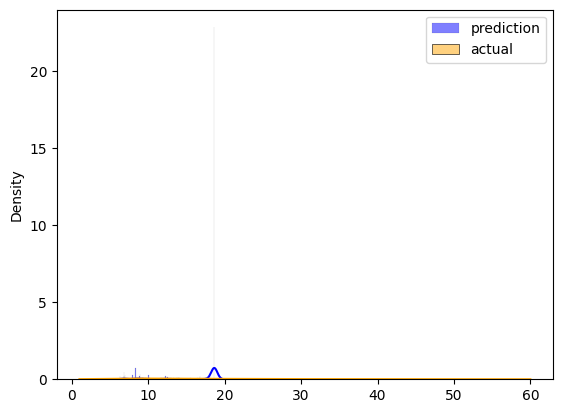

In [25]:
# Use histplot with kde=True to replace the deprecated distplot
sns.histplot(y_pred, label='prediction', kde=True, color='blue', stat="density", alpha=0.5)
sns.histplot(y_val, label='actual', kde=True, color='orange', stat="density", alpha=0.5)

# Use 'plt' instead of 'plot'
plt.legend()
plt.show()

In [26]:
lr = Ridge(0.01)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)

7.509752258177714

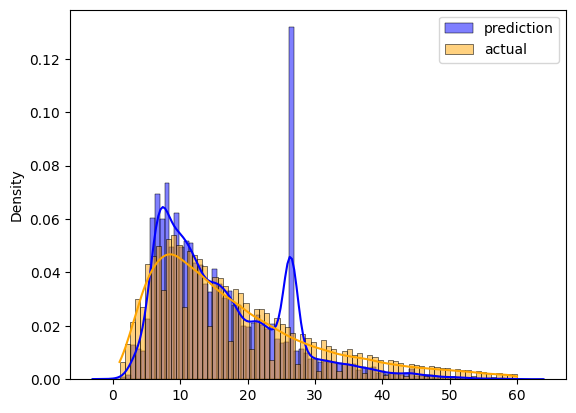

In [27]:
# Use histplot with kde=True to replace the deprecated distplot
sns.histplot(y_pred, label='prediction', kde=True, color='blue', stat="density", alpha=0.5)
sns.histplot(y_val, label='actual', kde=True, color='orange', stat="density", alpha=0.5)

# Use 'plt' instead of 'plot'
plt.legend()
plt.show()